# Subject Dependent Experiments

In [1]:
#model trained on one individual subject's samples, shuffled and divided into an 80-20 train-test split

In this notebook, we will apply EF-Net classifier to Hybrid EEG + fNIRS data with the data split in a Subject Dependent setting.

The dataset I am using is called: Simultaneous Acquisition of EEG and NIRS during Cognitive Tasks for
an Open Access Dataset,
    and is available here: https://doc.ml.tu-berlin.de/simultaneous_EEG_NIRS/. We are using Dataset C for classification.
    There is 36 NIRS channels. 30 EEG channels.

The current settings in this file will run the EF-Net model. (baseline_model==False). We also have the Deep Learning baselines here, that can be implemented using the 'baseline_model' boolean set to True, and further the 'resnet' boolean which indicates a resnet baseline to be used. If resnet==False, then the VGG baseline shall be implemented.
Deep learning parameters were set according to the table in the appendix of our published paper: [EF-Net: Mental State Recognition by Analyzing Multimodal EEG-fNIRS via CNN](https://doi.org/10.3390/s24061889). For more information on this code, please refer to this paper as well.

The dataset we have used is called: Simultaneous Acquisition of EEG and NIRS during Cognitive Tasks for
an Open Access Dataset, and is available here: https://doc.ml.tu-berlin.de/simultaneous_EEG_NIRS/. We are using Dataset C for classification. There are 72 fNIRS channels and 30 EEG channels. The dataset has 26 subjects in total. Each subject has data of 60 trials: which includes 3 sessions per subject, each session has 20 trials, each trial has 10 Word Generation tasks, and 10 Baseline tasks. This brings each subject to a total of 60 trials of either WG or BL tasks, performed in random order. Here we will further use those 60 trials to create 360 samples per subject, by using a sliding window technique across each trial.

In [2]:
import numpy as np
import tensorflow as tf
from data_preprocess import extract_subj_dep
import hybrid_model_structures as models

### Inputs - enter here:

In [3]:
#INPUT

#subjects directory path
#The data should be extracted in the same directory as this script.
dir_path_f = "./FNIRS_data/FNIRS2/NIRS_01-26_MATLAB/"
dir_path_e="./EEG_data/EEG2/EEG_01-26_MATLAB/"

#subject number 
subject="03"   

#result written to this file
result_file="eeg_fnirs_individual_subject_RESNETresults_38.txt"

#######################
#Deep Learning settings:

baseline_model=False    #using baselines or EFNet
resnet=False
if baseline_model:
    lr=0.00005
    EPOCHS=70
else:
    lr=0.001
    EPOCHS=70
BATCH_SIZE = 32
RANDOM_STATE=38


### Extracting samples from the data

In [4]:
X_eeg, X_fnirs, Y = extract_subj_dep(subject,baseline_model)

tasks shape (100, 72)
Length of data samples,  6
tasks shape (100, 72)
Length of data samples,  12
tasks shape (100, 72)
Length of data samples,  18
tasks shape (100, 72)
Length of data samples,  24
tasks shape (100, 72)
Length of data samples,  30
tasks shape (100, 72)
Length of data samples,  36
tasks shape (100, 72)
Length of data samples,  42
tasks shape (100, 72)
Length of data samples,  48
tasks shape (100, 72)
Length of data samples,  54
tasks shape (100, 72)
Length of data samples,  60
tasks shape (100, 72)
Length of data samples,  66
tasks shape (100, 72)
Length of data samples,  72
tasks shape (100, 72)
Length of data samples,  78
tasks shape (100, 72)
Length of data samples,  84
tasks shape (100, 72)
Length of data samples,  90
tasks shape (100, 72)
Length of data samples,  96
tasks shape (100, 72)
Length of data samples,  102
tasks shape (100, 72)
Length of data samples,  108
tasks shape (100, 72)
Length of data samples,  114
tasks shape (100, 72)
Length of data samples,  1

We now have an array of 360 samples from each subject. Each sample is a 5 second window from the task data, with one second of overlap with the previous sample.  
Secondly, we have an array Y made from the labels (y) array in session_markers from the dataset, and by appending the corresponding classes across the samples taken, we also have 360 trial labels per subject in the Y array.

### Standardizing the data, and then splitting the train-test partitions

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [6]:
# Standardize our signals data
# Reshaping the data samples into 2D applying the scaling and then reshaping back
scaler = StandardScaler()
XeegS = scaler.fit_transform(X_eeg.reshape(-1, X_eeg.shape[-1])).reshape(X_eeg.shape)
XfnirsS = scaler.fit_transform(X_fnirs.reshape(-1, X_fnirs.shape[-1])).reshape(X_fnirs.shape)

#adjustment to labels to make compatible with binary_crossentropy
Y=Y[:,0]

print(XeegS.shape)
print(XfnirsS.shape)
print(Y.shape)

(360, 500, 30, 1)
(360, 25, 72, 1)
(360,)


In [7]:
#reshaping data into correct form for input into models.
if baseline_model:
    XeegS_3D=XeegS
    XfnirsS_3D=XfnirsS
else:
    #reshape into 2D and 1 channel data (3D samples list) for EF-Net.
    XeegS_3D=np.reshape(XeegS,(XeegS.shape[0],XeegS.shape[1],XeegS.shape[2],1))
    XfnirsS_3D=np.reshape(XfnirsS,(XfnirsS.shape[0],XfnirsS.shape[1],XfnirsS.shape[2],1))
XeegS_3D.shape

(360, 500, 30, 1)

We now have an array of 360 samples for one subject as shown in output above. Each sample is a 5 second window from the task data, with one second of overlap with the previous sample.  
Secondly, we have an array Y made from the y array in session_markers data, and by appending the corresponding classes across the samples taken, we have 360 values in the Y array.

In [8]:
#Split all samples into training and testing splits
Xeeg_train, Xeeg_test, y_train, y_test = train_test_split(XeegS_3D, Y, test_size=0.2,random_state=RANDOM_STATE)
print(Xeeg_train.shape,Xeeg_test.shape)

Xfnirs_train, Xfnirs_test, y_train2, y_test2 = train_test_split(XfnirsS_3D, Y, test_size=0.2, random_state=RANDOM_STATE)
print(Xfnirs_train.shape, Xfnirs_test.shape)

#print(np.all(y_train==y_train2)) #check

(288, 500, 30, 1) (72, 500, 30, 1)
(288, 25, 72, 1) (72, 25, 72, 1)


### Applying a deep neural network to our data

In [9]:
if baseline_model:
    hybridmodel= models.eeg_fnirs_vgg(Xeeg_train,Xfnirs_train, resnet)
else:
    hybridmodel=models.eeg_fnirs_cnn_v2()

In [10]:
hybridmodel.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 30, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 494, 30, 32)  256         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 488, 30, 32)  7200        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 482, 30, 32)  7200        ['conv2d_1[0][0]']         

In [11]:
from tensorflow.keras.optimizers import Adam

hybridmodel.compile(optimizer=Adam(learning_rate=lr),loss='binary_crossentropy',metrics=['accuracy','Precision','Recall','AUC'])

In [12]:
#save best model weights

checkpoint_filepath = './tmp/checkpointef'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [13]:
hybridmodel.fit(x=[Xeeg_train, Xfnirs_train], y=y_train, validation_data=([Xeeg_test, Xfnirs_test], y_test), epochs=EPOCHS, callbacks=[model_checkpoint_callback])  

Epoch 1/70


2024-05-14 11:28:54.662578: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


9/9 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.6111 - precision: 0.6627 - recall: 0.3957 - auc: 0.6332
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to ./tmp/checkpointef
9/9 [==============================] - 5s 417ms/step - loss: 0.6835 - accuracy: 0.6111 - precision: 0.6627 - recall: 0.3957 - auc: 0.6332 - val_loss: 0.6620 - val_accuracy: 0.6250 - val_precision: 0.7188 - val_recall: 0.5610 - val_auc: 0.7305
Epoch 2/70
9/9 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.6736 - precision: 0.7184 - recall: 0.5324 - auc: 0.7252
Epoch 2: val_accuracy improved from 0.62500 to 0.66667, saving model to ./tmp/checkpointef
9/9 [==============================] - 4s 434ms/step - loss: 0.6557 - accuracy: 0.6736 - precision: 0.7184 - recall: 0.5324 - auc: 0.7252 - val_loss: 0.6366 - val_accuracy: 0.6667 - val_precision: 0.7297 - val_recall: 0.6585 - val_auc: 0.7132
Epoch 3/70
9/9 [==============================] - ETA: 0s - 

In [14]:
hybridmodel.load_weights(checkpoint_filepath)

In [15]:
probabilities = hybridmodel.predict([Xeeg_test, Xfnirs_test])

3/3 [==============================] - 0s 74ms/step


In [16]:
y_preds= np.round(probabilities)

Text(18.25, 0.5, 'Actual label')

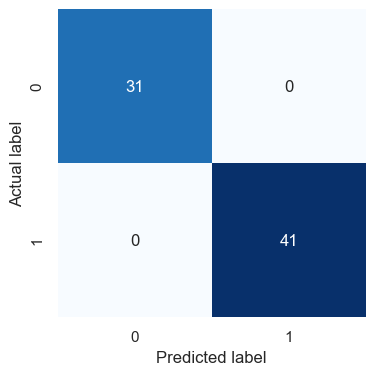

In [17]:
#confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


sns.set()

plt.figure(figsize=(4,4))

mat = confusion_matrix(y_test, y_preds )
labels = [0,1]

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted label')
plt.ylabel('Actual label')

In [18]:
loss,accuracy,precision,recall,AUC = hybridmodel.evaluate([Xeeg_test,Xfnirs_test], y_test)

3/3 [==============================] - 0s 81ms/step - loss: 0.0150 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000


In [19]:
#write run results to file
file1 = open(result_file, "a")  # append mode
write_string="subject="+str(subject)+" acc="+"{:.4f}".format(accuracy)+" precision="+"{:.4f}".format(precision)+" recall="+"{:.4f}".format(recall)+" AUC="+"{:.4f}".format(AUC)+" loss="+"{:.4f}".format(loss)+" seed="+str(RANDOM_STATE)+" \n"
file1.write(write_string)
file1.close()

In [20]:
print("subject= ",subject)
print("seed= ",RANDOM_STATE)
print("baseline?= ",baseline_model)
print("resnet?= ",resnet)

subject=  03
seed=  38
baseline?=  False
resnet?=  False
